# Overcoming a Theoretical Limitation of Self-Attention 

Replication of experiments on FIRST language learning from [Overcoming a Theoretical Limitation of Self-Attention  (Chiang and Cholak, 2022)](https://arxiv.org/pdf/2202.12172.pdf).

In [1]:
from src.transformer import FirstTransformer, FirstExactTransformer
import torch
import pandas as pd

Set the following to true to use the FirstExactTransformer, and to false to use FirstTransformer

In [2]:
EXACT = True

## Learning FIRST

Define training parameters as in the original paper. Citing from (David Chiang and Peter Cholak, 2020):
> We used `d_model` = 16 for word encodings, self-attention, and FFNN outputs, and `d_FFNN` = 64 for FFNN hidden layers. We used layer normalization (ε = 10^−5) after residual connections. We used PyTorch’s default initialization and trained using Adam (Kingma and Ba, 2015) with learning rate 3 × 10^−4 (Karpathy, 2016). We did not use dropout, as it did not seem to help.

In [3]:
log_sigmoid = torch.nn.LogSigmoid()
alphabet = ["0", "1", "$"]

epochs = 20
layers = 2
heads = 1 
if EXACT:
    d_model = 6 # do not change this!
else:
    d_model = 16
d_ffnn = 64  
scaled =False # log-length scaled attention
eps = 1e-5 # value added to denominator in layer normalization


Load training data and convert them to Tensor.

In [4]:
train = pd.read_csv("data/first/train.csv")
test = pd.read_csv("data/first/test.csv")

In [5]:
X_train, y_train = train['sequence'].values, train['label'].values
X_test, y_test = test['sequence'].values, test['label'].values

In [6]:
alphabet_index = {a:i for i,a in enumerate(alphabet)}

def _encode(s: str) -> torch.Tensor:
    t = torch.tensor([alphabet_index[c] for c in s])
    return t

X_train = [_encode(s) for s in X_train]
X_test = [_encode(s) for s in X_test]

Initialize the Transformer to learn FIRST.

In [7]:
transformer = \
    FirstExactTransformer(len(alphabet), d_model) if EXACT \
    else FirstTransformer(len(alphabet), layers, heads, d_model, d_ffnn, scaled, eps)
optim = torch.optim.Adam(transformer.parameters(), lr=0.0003)

Training cycle.

In [8]:
train_l = []
val_l = []
train_acc = []
val_acc = []

for epoch in range(epochs):

    train_loss = train_correct = 0    
    
    # train step
    for x, y in zip(X_train, y_train):

        output = transformer(x)

        if not y: output = -output

        if output > 0: train_correct += 1

        loss = -log_sigmoid(output)
        train_loss += loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()

    # save statistic about training step
    train_l.append(train_loss) # loss
    train_acc.append(train_correct/len(X_train)) # accuracy
        
    # validation step
    with torch.no_grad():

        test_loss = test_correct = 0

        for x, y in zip(X_test, y_test):

            output = transformer(x)

            if not y: output = -output

            if output > 0: test_correct += 1

            loss = -log_sigmoid(output)
            test_loss += loss.item()

    # save statistic about validation step
    val_l.append(test_loss) # loss
    val_acc.append(test_correct/len(X_test)) # accuracy

    # print step info
    print(f"[Epoch {epoch+1}] --> Train acc: {train_correct/len(X_train)} Train loss: {train_loss}, Test acc: {test_correct/len(X_test)} Test loss: {test_loss}", flush=True)

[Epoch 1] --> Train acc: 0.497 Train loss: 801.3432577773929, Test acc: 0.538 Test loss: 687.4118357896805
[Epoch 2] --> Train acc: 0.545 Train loss: 688.2728098034859, Test acc: 0.538 Test loss: 687.8652542233467
[Epoch 3] --> Train acc: 0.546 Train loss: 688.03924959898, Test acc: 0.538 Test loss: 687.3718031048775
[Epoch 4] --> Train acc: 0.546 Train loss: 687.3737273216248, Test acc: 0.538 Test loss: 686.5762986540794
[Epoch 5] --> Train acc: 0.551 Train loss: 686.2957746386528, Test acc: 0.538 Test loss: 685.2132209539413
[Epoch 6] --> Train acc: 0.557 Train loss: 684.2629755735397, Test acc: 0.538 Test loss: 682.3478423058987
[Epoch 7] --> Train acc: 0.58 Train loss: 678.4749752879143, Test acc: 0.54 Test loss: 670.6912103891373
[Epoch 8] --> Train acc: 0.819 Train loss: 460.9482701793313, Test acc: 1.0 Test loss: 111.36928904056549
[Epoch 9] --> Train acc: 1.0 Train loss: 44.54320336692035, Test acc: 1.0 Test loss: 15.165111013688147
[Epoch 10] --> Train acc: 1.0 Train loss: 8.2

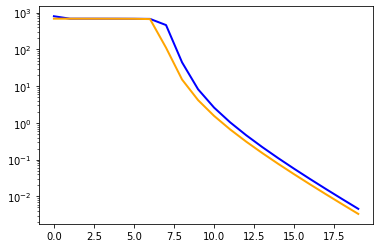

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(range(epoch+1), train_l, color='blue', lw=2)
plt.plot(range(epoch+1), val_l, color='orange', lw=2)
plt.yscale('log')
plt.show()

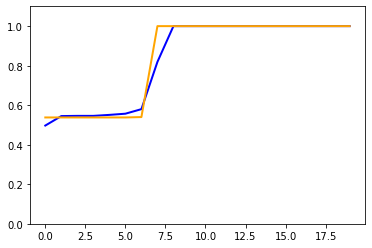

In [10]:
fig = plt.figure()
plt.plot(range(epoch+1), train_acc, color='blue', lw=2)
plt.plot(range(epoch+1), val_acc, color='orange', lw=2)
plt.ylim([0, 1.1])

plt.show()